# Import Everything
## Import necessary modules

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix

main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

import change_directory

os.chdir(main_path)

## Import data

In [4]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()
ccd_df = pd.read_csv("processed/non_transformed_credit_card_default.csv")
cd.change_to_notebook_dir()

## Extra Functions (Move to new file eventually)

In [11]:
def plot_confusion_matrix(model, X_train, X_test, y_train, y_test):
    model_cm = ConfusionMatrix(model)
    model_cm.fit(X_train, y_train)
    model_cm.score(X_test, y_test)
    model_cm.poof()

def all_scores(y_true, y_pred):
    print(f'f-1 score: {f1_score(y_true, y_pred)}')
    print(f'recall: {recall_score(y_true, y_pred)}')
    print(f'precision:{precision_score(y_true, y_pred)}')

# Begin Model Building
## Train-Test Split

In [6]:
X = ccd_df.drop('DEFAULT', axis=1)
y = ccd_df.DEFAULT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2819)

## Decision Tree

In [7]:
ccd_dt = DecisionTreeClassifier()
class_weights_gs = [{0:100, 1:1}, 'balanced', {0:10, 1:1}]
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth':[None, 8, 10],
              'min_samples_split':[10, 25],
              'min_samples_leaf':[1, 5],
              'max_features':[None, 'sqrt'], 
              'class_weight':class_weights_gs }

dt_gs = GridSearchCV(ccd_dt, param_grid, cv=3, scoring='f1', refit=True)

In [8]:
dt_gs.fit(X_train, y_train);

### Evaluating the best tree

In [9]:
best_tree = DecisionTreeClassifier(**dt_gs.best_params_)
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [12]:
y_preds_best_tree = best_tree.predict(X_test)
all_scores(y_test, y_preds_best_tree)

f-1 score: 0.5133789670192906
recall: 0.6283320639756284
precision:0.43398211467648606


### Confusion Matrix

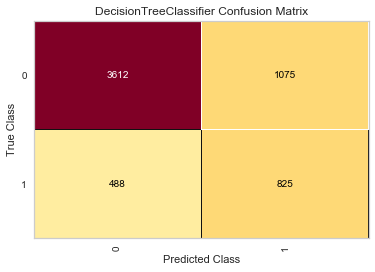

In [13]:
plot_confusion_matrix(best_tree, X_train, X_test, y_train, y_test)


## Random Forest

### Random Forest with the same hyperparameters as the best decision tree

In [14]:
ccd_rf = RandomForestClassifier(n_estimators=100, **dt_gs.best_params_)

In [15]:
ccd_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=25, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [16]:
y_preds = ccd_rf.predict(X_test)
all_scores(y_test, y_preds)

f-1 score: 0.5469387755102041
recall: 0.6123381568926123
precision:0.4941610325752919


In [17]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_preds)
print(auc(fpr, tpr))

0.7183730468696046


### Random Forest GridSearch

In [18]:
ccd_rf_clf_gs = RandomForestClassifier(n_estimators=100)

In [19]:
ccd_rf_gs_params = {
    'class_weight':['balanced', {0:1, 1:100}, {0:1, 1:50}, {0:1, 1:75}],
    'min_samples_leaf':[15, 20, 25],
    'min_samples_split':[40, 50, 70]
}
ccd_rf_gs = GridSearchCV(ccd_rf_clf_gs, ccd_rf_gs_params, cv=3, scoring='f1', n_jobs=-1)

In [20]:
ccd_rf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [21]:
ccd_rf_opt = RandomForestClassifier(**ccd_rf_gs.best_params_, n_estimators=100)

In [22]:
ccd_rf_opt.fit(X_train, y_train)
ccd_rf_opt_preds = ccd_rf_opt.predict(X_test)
all_scores(y_test, ccd_rf_opt_preds)
roc_auc_score(y_test, ccd_rf_opt_preds)

f-1 score: 0.5559368565545643
recall: 0.6169078446306169
precision:0.5059337913803873


0.7240715881996694

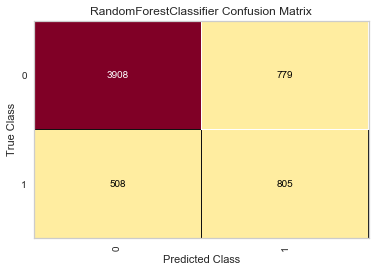

In [23]:
plot_confusion_matrix(ccd_rf_opt, X_train, X_test, y_train, y_test)

In [173]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, ccd_rf_opt.predict_proba(X_test)[:, 1])

## XGBoost

In [138]:
ccd_xgb = xgb.XGBClassifier(objective='binary:hinge')

In [139]:
xgb_gs_params = {
    'max_depth':[5, 6, 7, 8, 10]
}

xgb_gs = GridSearchCV(ccd_xgb, xgb_gs_params, scoring='f1', n_jobs=-1, cv=3)

In [140]:
xgb_gs.fit(X_train, y_train);

In [186]:
y_preds_xgb = xgb_gs.predict(X_test)
all_scores(y_test, y_preds_xgb)


0.4772170504654581

In [188]:
dtrain = xgb.DMatrix(X_train, label=np.array(y_train))
dtest = xgb.DMatrix(X_test, label=np.array(y_test))

In [155]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric':['error', 'auc'],
    'max_depth': 7
}

In [159]:
ccd_xgb = xgb.train(xgb_params, dtrain=dtrain, evals=[(dtest, 'Test')], num_boost_round=11)

[0]	Test-error:0.179333	Test-auc:0.76417
[1]	Test-error:0.179167	Test-auc:0.771551
[2]	Test-error:0.1785	Test-auc:0.775561
[3]	Test-error:0.176333	Test-auc:0.779066
[4]	Test-error:0.175833	Test-auc:0.781194
[5]	Test-error:0.176167	Test-auc:0.782922
[6]	Test-error:0.1775	Test-auc:0.783921
[7]	Test-error:0.176167	Test-auc:0.784484
[8]	Test-error:0.177167	Test-auc:0.784968
[9]	Test-error:0.178	Test-auc:0.78529
[10]	Test-error:0.178	Test-auc:0.786607


In [165]:
xgb_preds = (ccd_xgb.predict(dtest) >=0.5).astype(int)
all_scores(y_test, xgb_preds)

0.46865671641791046

In [171]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, ccd_xgb.predict(dtest))

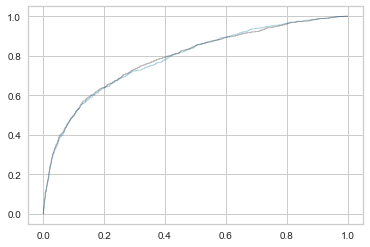

In [174]:
plt.plot(xgb_fpr, xgb_tpr, lw=1, alpha=0.3)
plt.plot(rf_fpr, rf_tpr, lw=1, alpha=0.3, color='k')

## Logistic Regression

In [24]:
ccd_lr = LogisticRegression(solver='liblinear', C=10)

In [25]:
ccd_lr.fit(X_train, y_train);

In [26]:
y_preds_lr = ccd_lr.predict(X_test)
recall_score(y_test, y_preds_lr)

0.0

In [27]:
ccd_lr.score(X_test, y_test)

0.781

# Upsampling, Downsampling, SMOTE

In [29]:
pos_samples = ccd_df[ccd_df.DEFAULT == 1]
neg_samples = ccd_df[ccd_df.DEFAULT == 0]

num_pos = pos_samples.shape[0]
num_neg = neg_samples.shape[0]

print(f"Number of defaults:{num_pos}")
print(f"Number of non-defaults: {num_neg}")

Number of defaults:6636
Number of non-defaults: 23364


## Upsampling

In [30]:
pos_samples_train, pos_samples_test = train_test_split(
    pos_samples, test_size=0.2)
neg_samples_train, neg_samples_test = train_test_split(
    neg_samples, test_size=0.2)

ups_pos_idx = np.random.choice(
    pos_samples_train.index, size=neg_samples_train.shape[0], replace=True)
ups_pos = pos_samples_train.loc[ups_pos_idx, :]

In [31]:
ccd_upsampled = pd.concat([ups_pos, neg_samples_train], axis=0)
X_ups = ccd_upsampled.drop('DEFAULT', axis=1)
y_ups = ccd_upsampled.DEFAULT

ccd_ups_test = pd.concat([pos_samples_test, neg_samples_test], axis=0)
X_ups_test = ccd_ups_test.drop('DEFAULT', axis=1)
y_ups_test = ccd_ups_test.DEFAULT

In [32]:
ccd_ups_rf_gs_clf = RandomForestClassifier(n_estimators=100)

ccd_ups_rf_gs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [10, 20, 30, 40]
}

ccd_ups_rf_gs = GridSearchCV(ccd_ups_rf_gs_clf, ccd_ups_rf_gs_params, scoring='recall', cv=3)

In [33]:
ccd_ups_rf_gs.fit(X_ups, y_ups)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [34]:
ccd_ups_rf_gs.best_score_

0.8474666952008988

In [36]:
best_ups_rf_model = RandomForestClassifier(**ccd_ups_rf_gs.best_params_, n_estimators=100)
best_ups_rf_model.fit(X_ups, y_ups)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [37]:
best_ups_rf_preds = best_ups_rf_model.predict(X_ups_test)
all_scores(y_ups_test, best_ups_rf_preds)

f-1 score: 0.5408279529054311
recall: 0.536144578313253
precision:0.5455938697318008


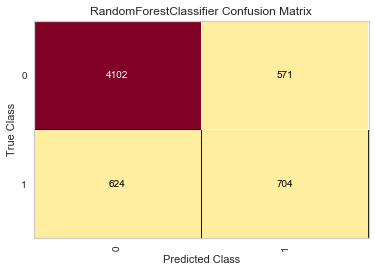

In [38]:
plot_confusion_matrix(best_ups_rf_model, X_ups, X_ups_test, y_ups, y_ups_test)

## Downsampling

In [39]:
downs_neg_idx = np.random.choice(neg_samples.index, size=num_pos, replace=False)
downs_neg = neg_samples.loc[downs_neg_idx, :]
ccd_downsample = pd.concat([downs_neg, pos_samples], axis=0)

X_downs = ccd_downsample.drop('DEFAULT', axis=1)
y_downs = ccd_downsample.DEFAULT

X_train_downs, X_test_downs, y_train_downs, y_test_downs = train_test_split(X_downs, y_downs, test_size=0.2)

In [40]:
ccd_downs_rf_gs_clf = RandomForestClassifier(n_estimators=100)

ccd_downs_rf_gs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [10, 20, 30, 40]
}

ccd_downs_rf_gs = GridSearchCV(ccd_downs_rf_gs_clf, ccd_downs_rf_gs_params, scoring='recall', cv=3)

In [41]:
ccd_downs_rf_gs.fit(X_train_downs, y_train_downs)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [43]:
best_downs_rf_model = ccd_downs_rf_gs.best_estimator_
best_downs_rf_preds = best_downs_rf_model.predict(X_test_downs)
all_scores(y_test_downs, best_downs_rf_preds)

f-1 score: 0.6818747407714641
recall: 0.623199393479909
precision:0.7527472527472527


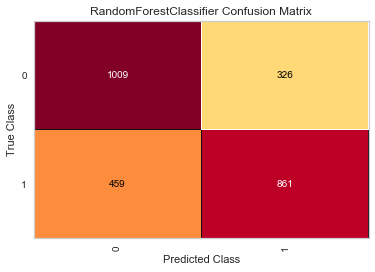

In [260]:
plot_confusion_matrix(best_downs_rf_model, X_train_downs, X_test_downs, y_train_downs, y_test_downs)

## SMOTE

In [45]:
ccd_smote = SMOTE()

X = ccd_df.drop('DEFAULT', axis=1)
y = ccd_df.DEFAULT

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.2)
X_sm, y_sm = ccd_smote.fit_resample(X_train_sm, y_train_sm)

In [46]:
ccd_sm_rf_gs_clf = RandomForestClassifier(n_estimators=100)

ccd_sm_rf_gs_params = {
    'class_weight': ['balanced'],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [10, 20, 30, 40]
}

ccd_sm_rf_gs = GridSearchCV(ccd_sm_rf_gs_clf, ccd_sm_rf_gs_params, scoring='recall', cv=3)

In [47]:
ccd_sm_rf_gs.fit(X_sm, y_sm);

f-1 score: 0.5217021276595744
recall: 0.4619442351168048
precision:0.5992179863147605


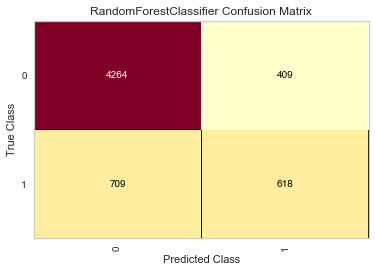

In [48]:
best_sm_rf_model = ccd_sm_rf_gs.best_estimator_
best_sm_rf_preds = best_sm_rf_model.predict(X_test_sm)
all_scores(y_test_sm, best_sm_rf_preds)
plot_confusion_matrix(best_sm_rf_model, X_sm, X_test_sm, y_sm, y_test_sm)

# Fully transformed data

## Oversampled Data

TypeError: file must have 'read' and 'readline' attributes